<a href="https://colab.research.google.com/github/jpatrickweller/Data_Challenges/blob/main/Ice_Cream_Sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
register_matplotlib_converters()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Import the data
url = 'https://raw.githubusercontent.com/ritvikmath/Time-Series-Analysis/master/ice_cream.csv'
df = pd.read_csv(url)
df.head()

,DATE,IPN31152N
0,1972-01-01,59.9622
1,1972-02-01,67.0605
2,1972-03-01,74.2350
3,1972-04-01,78.1120
4,1972-05-01,84.7636


In [3]:
# Let's rename the columns first
df.rename(columns={'DATE':'date','IPN31152N':'production'}, inplace=True)

# Convert the date to datetime
df['date'] = pd.to_datetime(df['date'])

df

,date,production
0,1972-01-01,59.9622
1,1972-02-01,67.0605
2,1972-03-01,74.2350
3,1972-04-01,78.1120
4,1972-05-01,84.7636
...,...,...
572,2019-09-01,100.1741
573,2019-10-01,90.1684
574,2019-11-01,79.7223
575,2019-12-01,75.7094


In [4]:
# Set date as the index
df.set_index(keys='date', inplace=True)
df

,production
date,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636
...,...
2019-09-01,100.1741
2019-10-01,90.1684
2019-11-01,79.7223


In [5]:
# Let's narrow our range, just for practical purposes
start_date = pd.to_datetime('2010-01-01')
icdf = df[start_date::]

icdf

,production
date,
2010-01-01,91.2895
2010-02-01,110.4994
2010-03-01,127.0971
2010-04-01,132.6468
2010-05-01,134.5576
...,...
2019-09-01,100.1741
2019-10-01,90.1684
2019-11-01,79.7223


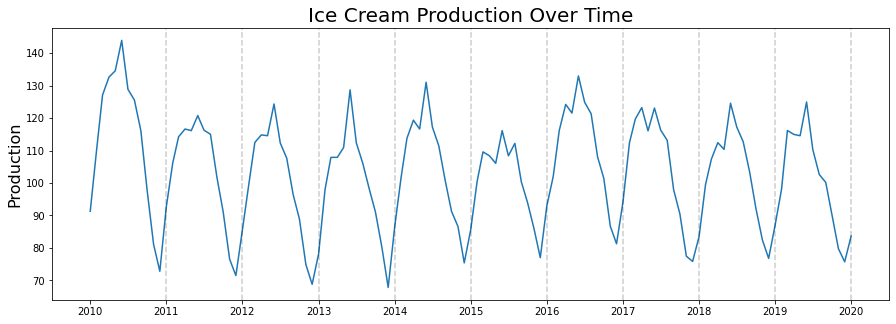

In [6]:
# Plot this data!

plt.figure(figsize=(15,5))
plt.plot(icdf.production)
plt.title('Ice Cream Production Over Time', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(2011,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=.2)

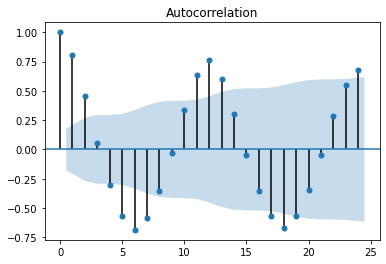

In [7]:
acf_plot = plot_acf(icdf.production, lags=24)

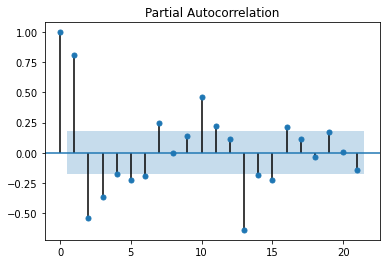

In [8]:
pacf_plot = plot_pacf(icdf.production)

In [9]:
# based on the pacf above, we can start with an AR model with legs = 1, 2, 3

In [10]:
# Train/test split
import datetime as dt

train_end = dt.datetime(2016,12,1)
test_end = dt.datetime(2019,12,1)

train_data = icdf[:train_end]
test_data = icdf[train_end + dt.timedelta(days=1):test_end]

In [11]:
from statsmodels.tsa.arima_model import ARMA

# create the model
model = ARMA(train_data, order=(3,0))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
